## Objective:
Create relationship between the Cabin study data and segments and/or water bodies.

In [2]:
import geopandas as gpd
import pandas as pd
import fiona
# from ipyfilechooser import FileChooser
from shapely.geometry import Polygon, LineString, Point
from geopandas import GeoSeries

import itertools
from operator import itemgetter

import numpy as np

from scipy.spatial import cKDTree


/home/javad/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Steps:
- Convert lon and lot from Cabin data to Points
- Use the two functions in `Barrier-Waterbody-segments-connection` file
- Find the closest segment and water body to each study point
- Export the results as CSv for Neo4j

In [3]:
# read study
# create points
st_df = pd.read_csv('data/CABIN-data-20210307/NL_cabin_study_data_mda02_1987-present.csv')
st_df = gpd.GeoDataFrame(
    st_df, geometry=gpd.points_from_xy(st_df.Longitude, st_df.Latitude), crs="EPSG:4326")# crs of waterbodies is 4326

<AxesSubplot:>

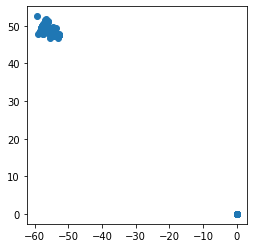

In [10]:
st_df.plot()

In [4]:
np.__version__

'1.19.1'

In [5]:
st_df = st_df[['Type/Type', 'geometry']]

## Study location and segments relationship
Find the closest segment to each study

<AxesSubplot:>

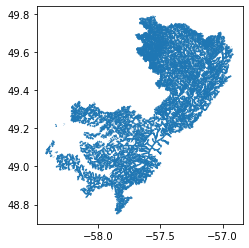

In [62]:
fl_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HN_NLFLOW_1.shp')
fl_df.plot()

In [63]:
x = fl_df.geometry[0]
list(x.xy)
ll = LineString([xy[:2] for xy in list(x.xy)])
x.has_z

True

In [84]:
# the data from open canada is 3d meaning it has a Z dimension

from shapely.geometry import Polygon, MultiPolygon, shape, Point, LineString
import geopandas as gpd

# the function is taken from this code snippet then modified for Linestring
# https://gist.github.com/rmania/8c88377a5c902dfbc134795a7af538d8

def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    Edited by Javad:  changes Poly to Linestring and used xy attribute, added else 
    '''
    new_geo = []
    for p in geometry:
#         print(p.has_z)
        if p.has_z:
            if p.geom_type == 'LineString':
                lines = [xy[:2] for xy in list(p.xy)]
                new_p = LineString(lines)
                new_geo.append(new_p)
            elif p.geom_type == 'MultiPolygon':
                new_multi_p = []
                for ap in p:
                    lines = [xy[:2] for xy in list(ap.exterior.coords)]
                    new_p = Polygon(lines)
                    new_multi_p.append(new_p)
                new_geo.append(MultiPolygon(new_multi_p))
        else:
            new_geo.append(p) # to handle if it is already a 2d
            
    return new_geo

fl_df.geometry = convert_3D_2D(fl_df.geometry) # new geodf with 2D geometry series

In [66]:
# a function for finding the closest point:

def ckdnearest_line(gdfA, gdfB, gdfB_cols=['name']):
    """ A is point and B is Linestring """
    # resetting the index of gdfA and gdfB here.
    gdfA = gdfA.reset_index(drop=True)
    gdfB = gdfB.reset_index(drop=True)
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.geometry.to_list()]
    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)
    idx = itemgetter(*idx)(B_ix)
    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf



In [67]:

# columns to keep from study data frame:
st_cols = ['NID']#st_df.columns
st_fl_nearest_df = ckdnearest_line( st_df, geodf_2d, st_cols)

In [68]:
st_fl_nearest_df


,Type/Type,geometry,NID,dist
0,River,POINT (-58.15167 48.68944),4a42ce8a5ffb4215bb7030f72e1d67bb,105.609944
1,River,POINT (-58.02861 48.78750),4a42ce8a5ffb4215bb7030f72e1d67bb,105.706623
2,River,POINT (-57.73306 49.40361),4a42ce8a5ffb4215bb7030f72e1d67bb,106.320009
3,River,POINT (-57.57194 50.09083),42a74260c27346ed8e9ffe10ed1c2201,106.331835
4,River,POINT (-57.49528 50.27361),42a74260c27346ed8e9ffe10ed1c2201,106.257636
...,...,...,...,...
345,River,POINT (-54.03028 48.43611),42a74260c27346ed8e9ffe10ed1c2201,102.782217
346,River,POINT (-54.03028 48.43611),42a74260c27346ed8e9ffe10ed1c2201,102.782217
347,River,POINT (-53.91528 48.62444),42a74260c27346ed8e9ffe10ed1c2201,102.666812
348,River,POINT (-54.00000 48.00000),42a74260c27346ed8e9ffe10ed1c2201,102.754204


<AxesSubplot:>

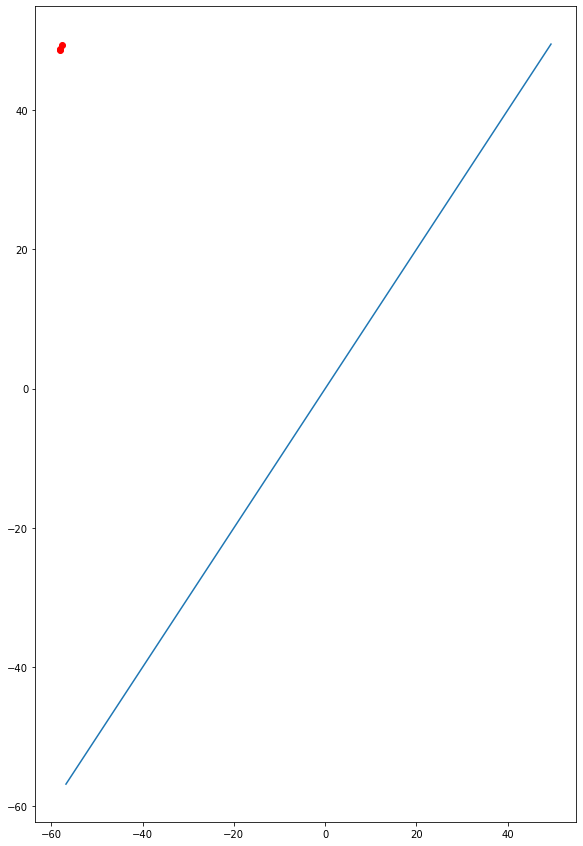

In [83]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
geodf_2d[geodf_2d['NID'] == '4a42ce8a5ffb4215bb7030f72e1d67bb'].plot(ax=ax)
st_fl_nearest_df.iloc[0:3,:].plot(color='red', ax= ax)

In [81]:
st_fl_nearest_df.iloc[0:2,:]

,Type/Type,geometry,NID,dist
0,River,POINT (-58.15167 48.68944),4a42ce8a5ffb4215bb7030f72e1d67bb,105.609944
1,River,POINT (-58.02861 48.78750),4a42ce8a5ffb4215bb7030f72e1d67bb,105.706623


## TODO:
- Clean this and repeat for waterbodies
- Export the results